# App Rating Prediction

### Rohit Gaurav Mishra

DESCRIPTION

**Objective:** Make a model to predict the app rating, with other information about the app provided.

**Problem Statement:**

Google Play Store team is about to launch a new feature wherein, certain apps that are promising, are boosted in visibility. The boost will manifest in multiple ways including higher priority in recommendations sections (“Similar apps”, “You might also like”, “New and updated games”). These will also get a boost in search results visibility.  This feature will help bring more attention to newer apps that have the potential.

#### 1. Load the data file using pandas

In [1]:
# Importing the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
# Importing the data
df = pd.read_csv('googleplaystore.csv')

In [3]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null object
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


#### 2. Check for null values in the data. Get the number of null values for each column.

In [5]:
df.isnull().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

The column **Rating** has the most null values.

#### 3. Drop records with nulls in any of the columns.

In [6]:
df.dropna(axis = 0, inplace=True)

In [7]:
df.reset_index(inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9360 entries, 0 to 9359
Data columns (total 14 columns):
index             9360 non-null int64
App               9360 non-null object
Category          9360 non-null object
Rating            9360 non-null float64
Reviews           9360 non-null object
Size              9360 non-null object
Installs          9360 non-null object
Type              9360 non-null object
Price             9360 non-null object
Content Rating    9360 non-null object
Genres            9360 non-null object
Last Updated      9360 non-null object
Current Ver       9360 non-null object
Android Ver       9360 non-null object
dtypes: float64(1), int64(1), object(12)
memory usage: 1023.9+ KB


The data frame is now free from any null records.

#### 4. Variables seem to have incorrect type and inconsistent formatting. You need to fix them:

##### 1. Size column has sizes in Kb as well as Mb. To analyze, you’ll need to convert these to numeric.

1. Extract the numeric value from the column

2. Multiply the value by 1,000, if size is mentioned in Mb

Let us first check if the data frame has any value apart from the ones mentioned in MB or kB. We will then check how to treat those.

In [9]:
df[(df['Size'].str.endswith('M') == False) & (df['Size'].str.endswith('k') == False)]['Size'].value_counts()

Varies with device    1637
Name: Size, dtype: int64

There is a value **Varies with device** on 1637 records. We will need to remove these records as these are as good as null values for us.

In [10]:
df = df[df['Size'] != 'Varies with device']

In [11]:
df[(df['Size'].str.endswith('M') == False) & (df['Size'].str.endswith('k') == False)]['Size'].value_counts()

Series([], Name: Size, dtype: int64)

We will now tackle the problem at hand.

In [12]:
df['Size'] = df['Size'].apply(lambda x: float(x.split('M')[0]) * 1000 if x.endswith('M') else float(x.split('k')[0]))

In [13]:
df['Size'].head()

0    19000.0
1    14000.0
2     8700.0
3    25000.0
4     2800.0
Name: Size, dtype: float64

The **Size** column is therefore transformed into a numeric type with values corrected.

##### 2. Reviews is a numeric field that is loaded as a string field. Convert it to numeric (int/float).

In [14]:
df['Reviews'] = df['Reviews'].astype('int64')

In [15]:
df['Reviews'].head()

0       159
1       967
2     87510
3    215644
4       967
Name: Reviews, dtype: int64

**Reviews** column is converted to 64 bit integer

##### 3. Installs field is currently stored as string and has values like 1,000,000+.

1. Treat 1,000,000+ as 1,000,000

2. Remove ‘+’, ‘,’ from the field, convert it to integer

In [16]:
df['Installs'] = df['Installs'].apply(lambda x: int(x.replace('+', '').replace(',', '')))

##### 4. Price field is a string and has a symbol. Remove ‘$’ sign, and convert it to numeric.

In [17]:
df['Price'] = df['Price'].apply(lambda x: float(x.replace('$', '')))

#### 5. Sanity Checks

##### 1. Average rating should be between 1 and 5 as only these values are allowed on the play store. Drop the rows that have a value outside this range.

In [18]:
df[(df['Rating'] < 1) | (df['Rating'] > 5)]

,index,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver


No such record exists where the **Rating** is **<1 or >5**

##### 2. Reviews should not be more than installs as only those who installed can review the app. If there are any such records, drop them.

In [19]:
df[df['Reviews'] > df['Installs']]

,index,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
2340,2454,KBA-EZ Health Guide,MEDICAL,5.0,4,25000.0,1,Free,0.00,Everyone,Medical,"August 2, 2018",1.0.72,4.0.3 and up
5535,5917,Ra Ga Ba,GAME,5.0,2,20000.0,1,Paid,1.49,Everyone,Arcade,"February 8, 2017",1.0.4,2.3 and up
6144,6700,Brick Breaker BR,GAME,5.0,7,19000.0,5,Free,0.00,Everyone,Arcade,"July 23, 2018",1.0,4.1 and up
6616,7402,Trovami se ci riesci,GAME,5.0,11,6100.0,10,Free,0.00,Everyone,Arcade,"March 11, 2017",0.1,2.3 and up
7592,8591,DN Blog,SOCIAL,5.0,20,4200.0,10,Free,0.00,Teen,Social,"July 23, 2018",1.0,4.0 and up
9260,10697,Mu.F.O.,GAME,5.0,2,16000.0,1,Paid,0.99,Everyone,Arcade,"March 3, 2017",1.0,2.3 and up


In [20]:
df.drop(df.loc[df['Reviews'] > df['Installs']].index, axis = 0, inplace=True)

We will also drop the unneccessary column index as we already reset it.

In [21]:
df.drop(['index'], axis = 1, inplace=True)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7717 entries, 0 to 9359
Data columns (total 13 columns):
App               7717 non-null object
Category          7717 non-null object
Rating            7717 non-null float64
Reviews           7717 non-null int64
Size              7717 non-null float64
Installs          7717 non-null int64
Type              7717 non-null object
Price             7717 non-null float64
Content Rating    7717 non-null object
Genres            7717 non-null object
Last Updated      7717 non-null object
Current Ver       7717 non-null object
Android Ver       7717 non-null object
dtypes: float64(3), int64(2), object(8)
memory usage: 844.0+ KB


In [23]:
df[(df['Type'] == 'Free') & (df['Price'] >0)]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver


No such record exists where the app **Type** is **Free** and **Price** is **>0**

#### 6. Performing univariate analysis:

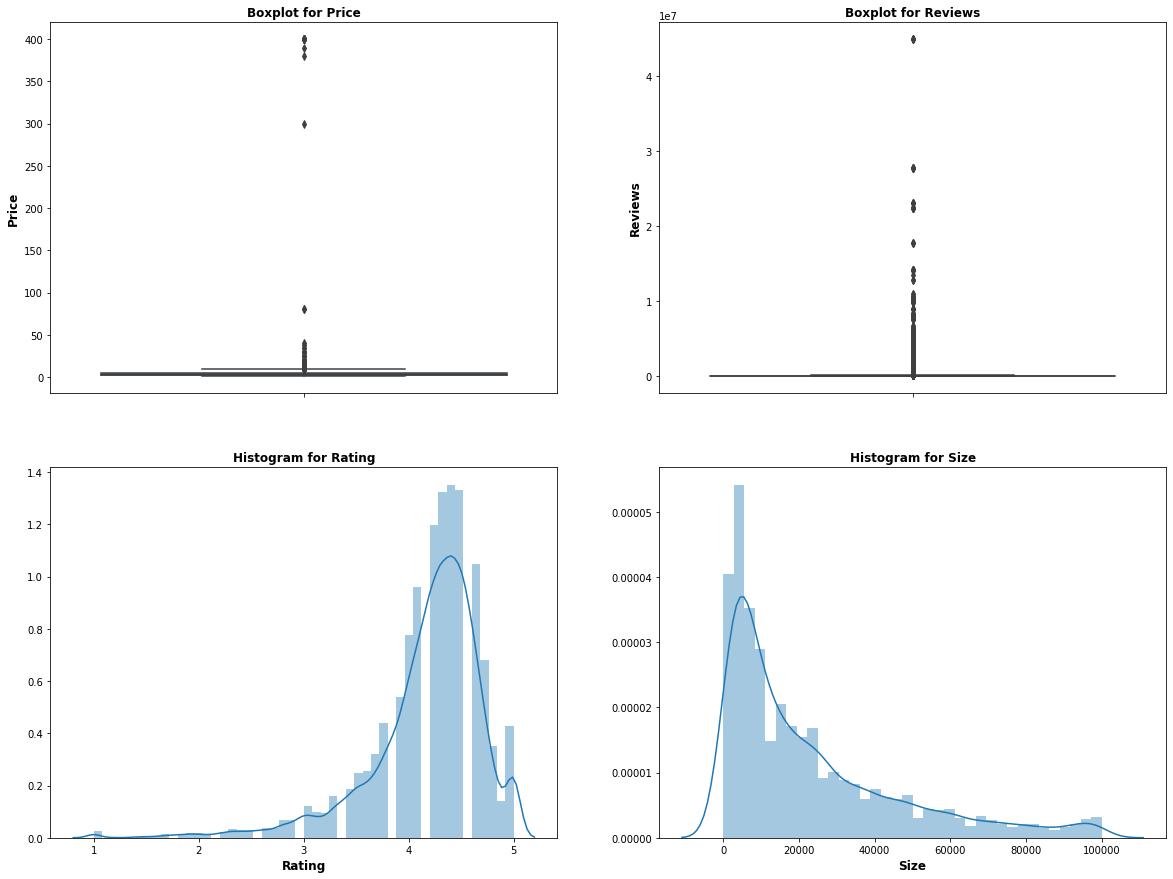

In [24]:
fig, axes = plt.subplots(2, 2, figsize = (20, 15))
axes[0, 0].set_title('Boxplot for Price', fontsize = 12, fontweight = 'semibold')
axes[0, 0].set_ylabel('Price', fontsize = 12, fontweight = 'semibold')
sns.boxplot(y = 'Price', data = df[df['Price'] != 0], ax = axes[0, 0])
axes[0, 1].set_title('Boxplot for Reviews', fontsize = 12, fontweight = 'semibold')
axes[0, 1].set_ylabel('Reviews', fontsize = 12, fontweight = 'semibold')
sns.boxplot(y = 'Reviews', data = df, ax = axes[0, 1])
axes[1, 0].set_title('Histogram for Rating', fontsize = 12, fontweight = 'semibold')
axes[1, 0].set_xlabel('Ratings', fontsize = 12, fontweight = 'semibold')
sns.distplot(df['Rating'], ax = axes[1, 0])
axes[1, 1].set_title('Histogram for Size', fontsize = 12, fontweight = 'semibold')
axes[1, 1].set_xlabel('Size', fontsize = 12, fontweight = 'semibold')
sns.distplot(df['Size'], ax = axes[1, 1]);

We can infer the following by observing the 
<ul>* Price of most of the apps seems to be nominal. It is mostly a little over 0 USD for a large number of apps.</ul>
<ul>* There are a few apps that have an unusually large number of reviews.</ul>
<ul>* The rating for maximum number of apps is concentrated between 4 & 5</ul>
<ul>* The most common size of the apps is around 5-10 MB</ul>

#### 7. Outlier treatment:

##### 1. Price: From the box plot, it seems like there are some apps with very high price. A price of $200 for an application on the Play Store is very high and suspicious!

We will drop all records where the price is >= 200$

In [25]:
df.loc[df['Price'] >=200]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
4036,most expensive app (H),FAMILY,4.3,6,1500.0,100,Paid,399.99,Everyone,Entertainment,"July 16, 2018",1.0,7.0 and up
4189,💎 I'm rich,LIFESTYLE,3.8,718,26000.0,10000,Paid,399.99,Everyone,Lifestyle,"March 11, 2018",1.0.0,4.4 and up
4194,I'm Rich - Trump Edition,LIFESTYLE,3.6,275,7300.0,10000,Paid,400.00,Everyone,Lifestyle,"May 3, 2018",1.0.1,4.1 and up
5042,I am rich,LIFESTYLE,3.8,3547,1800.0,100000,Paid,399.99,Everyone,Lifestyle,"January 12, 2018",2.0,4.0.3 and up
5045,I am Rich Plus,FAMILY,4.0,856,8700.0,10000,Paid,399.99,Everyone,Entertainment,"May 19, 2018",3.0,4.4 and up
5046,I am rich VIP,LIFESTYLE,3.8,411,2600.0,10000,Paid,299.99,Everyone,Lifestyle,"July 21, 2018",1.1.1,4.3 and up
5047,I Am Rich Premium,FINANCE,4.1,1867,4700.0,50000,Paid,399.99,Everyone,Finance,"November 12, 2017",1.6,4.0 and up
5048,I am extremely Rich,LIFESTYLE,2.9,41,2900.0,1000,Paid,379.99,Everyone,Lifestyle,"July 1, 2018",1.0,4.0 and up
5049,I am Rich!,FINANCE,3.8,93,22000.0,1000,Paid,399.99,Everyone,Finance,"December 11, 2017",1.0,4.1 and up
5050,I am rich(premium),FINANCE,3.5,472,965.0,5000,Paid,399.99,Everyone,Finance,"May 1, 2017",3.4,4.4 and up


In [26]:
df.drop(df.loc[df['Price'] >=200].index, axis = 0, inplace=True)

##### 2. Reviews: Very few apps have very high number of reviews. These are all star apps that don’t help with the analysis and, in fact, will skew it. Drop records having more than 2 million reviews.

In [27]:
df.loc[df['Reviews'] >=2000000]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
332,Yahoo Mail – Stay Organized,COMMUNICATION,4.3,4187998,16000.0,100000000,Free,0.0,Everyone,Communication,"July 18, 2018",5.29.3,4.4 and up
334,imo free video calls and chat,COMMUNICATION,4.3,4785892,11000.0,500000000,Free,0.0,Everyone,Communication,"June 8, 2018",9.8.000000010501,4.0 and up
353,UC Browser Mini -Tiny Fast Private & Secure,COMMUNICATION,4.4,3648120,3300.0,100000000,Free,0.0,Teen,Communication,"July 18, 2018",11.4.0,4.0 and up
365,UC Browser - Fast Download Private & Secure,COMMUNICATION,4.5,17712922,40000.0,500000000,Free,0.0,Teen,Communication,"August 2, 2018",12.8.5.1121,4.0 and up
370,imo free video calls and chat,COMMUNICATION,4.3,4785988,11000.0,500000000,Free,0.0,Everyone,Communication,"June 8, 2018",9.8.000000010501,4.0 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8053,Need for Speed™ No Limits,GAME,4.4,3344300,22000.0,50000000,Free,0.0,Everyone 10+,Racing,"July 24, 2018",2.12.1,4.1 and up
8076,Modern Combat 5: eSports FPS,GAME,4.3,2903386,58000.0,100000000,Free,0.0,Mature 17+,Action,"July 24, 2018",3.2.1c,4.0 and up
8883,Farm Heroes Saga,FAMILY,4.4,7615646,71000.0,100000000,Free,0.0,Everyone,Casual,"August 7, 2018",5.2.6,2.3 and up
8886,Fallout Shelter,FAMILY,4.6,2721923,25000.0,10000000,Free,0.0,Teen,Simulation,"June 11, 2018",1.13.12,4.1 and up


In [28]:
df.drop(df.loc[df['Reviews'] >=2000000].index, axis = 0, inplace=True)

##### 3. Installs:  There seems to be some outliers in this field too. Apps having very high number of installs should be dropped from the analysis.

1. Find out the different percentiles – 10, 25, 50, 70, 90, 95, 99

In [29]:
df[['Installs']].quantile([0.1, 0.25, 0.5, 0.7, 0.9, 0.95, 0.99])

,Installs
0.10,1000.0
0.25,10000.0
0.50,100000.0
0.70,1000000.0
0.90,10000000.0
0.95,10000000.0
0.99,50000000.0


Table above shows the distribution in terms of the mentioned quantiles for the column **Installs**

2. Decide a threshold as cutoff for outlier and drop records having values more than that

In [30]:
len(df[df['Installs'] > 50000000.0])

60

There seem to be only very few rows with **Installs** > 50000000. We will get rid of these rows as they are most probably outliers in our data

In [31]:
df = df[df['Installs'] < 50000000.0]

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7307 entries, 0 to 9359
Data columns (total 13 columns):
App               7307 non-null object
Category          7307 non-null object
Rating            7307 non-null float64
Reviews           7307 non-null int64
Size              7307 non-null float64
Installs          7307 non-null int64
Type              7307 non-null object
Price             7307 non-null float64
Content Rating    7307 non-null object
Genres            7307 non-null object
Last Updated      7307 non-null object
Current Ver       7307 non-null object
Android Ver       7307 non-null object
dtypes: float64(3), int64(2), object(8)
memory usage: 799.2+ KB


#### 8. Bivariate analysis:

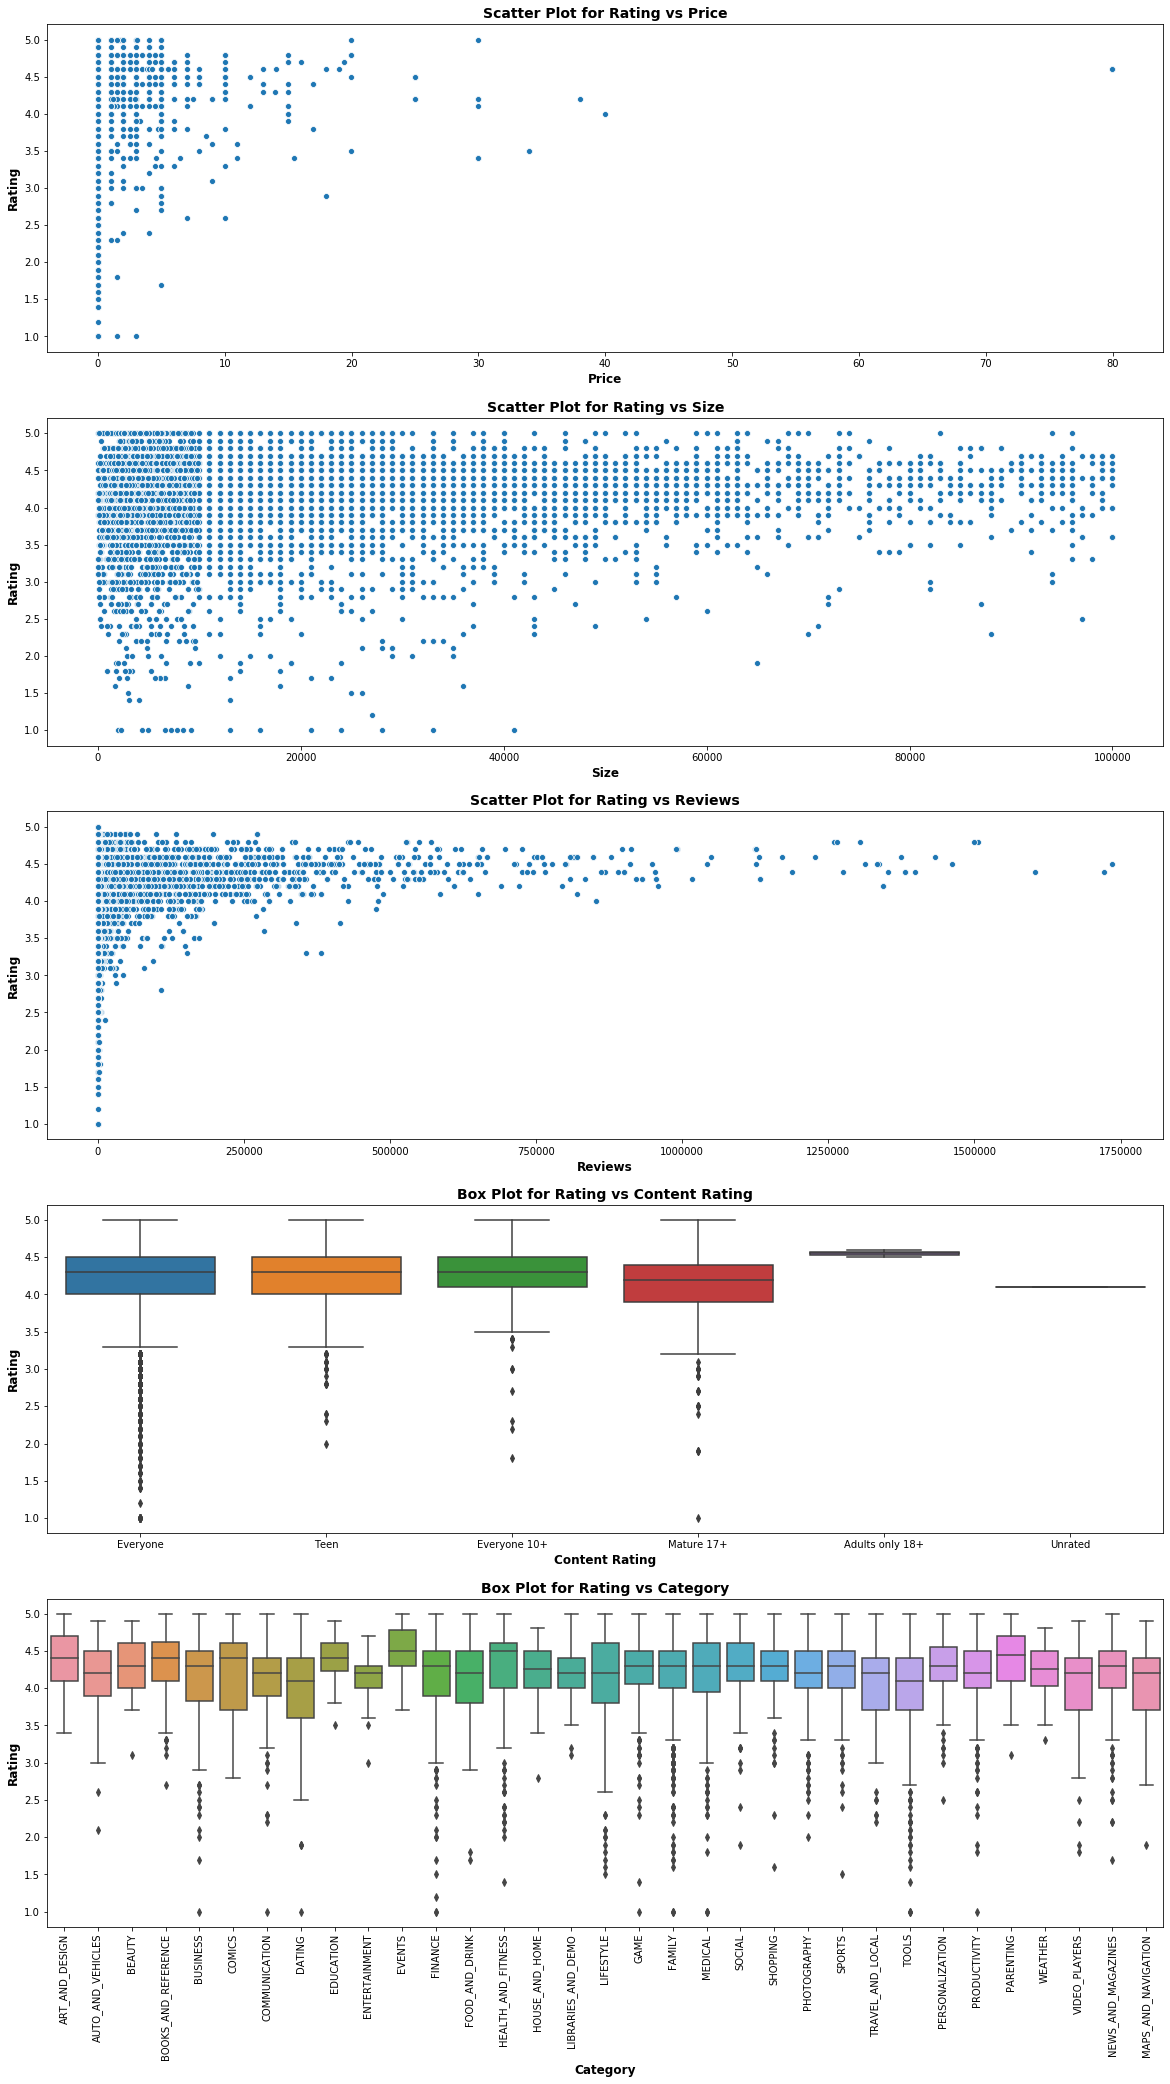

In [33]:
fig, axes = plt.subplots(5, 1, figsize = (20, 35))
axes[0].set_title('Scatter Plot for Rating vs Price', fontsize = 14, fontweight = 'semibold')
axes[0].set_xlabel('Price', fontsize = 12, fontweight = 'semibold')
axes[0].set_ylabel('Rating', fontsize = 12, fontweight = 'semibold')
sns.scatterplot(x = 'Price', y = 'Rating', data = df, ax = axes[0])
axes[1].set_title('Scatter Plot for Rating vs Size', fontsize = 14, fontweight = 'semibold')
axes[1].set_xlabel('Size', fontsize = 12, fontweight = 'semibold')
axes[1].set_ylabel('Rating', fontsize = 12, fontweight = 'semibold')
sns.scatterplot(x = 'Size', y = 'Rating', data = df, ax = axes[1])
axes[2].set_title('Scatter Plot for Rating vs Reviews', fontsize = 14, fontweight = 'semibold')
axes[2].set_xlabel('Reviews', fontsize = 12, fontweight = 'semibold')
axes[2].set_ylabel('Rating', fontsize = 12, fontweight = 'semibold')
sns.scatterplot(x = 'Reviews', y = 'Rating', data = df, ax = axes[2])
axes[3].set_title('Box Plot for Rating vs Content Rating', fontsize = 14, fontweight = 'semibold')
axes[3].set_xlabel('Content Rating', fontsize = 12, fontweight = 'semibold')
axes[3].set_ylabel('Rating', fontsize = 12, fontweight = 'semibold')
sns.boxplot(x = 'Content Rating', y = 'Rating', data = df, ax = axes[3])
axes[4].set_title('Box Plot for Rating vs Category', fontsize = 14, fontweight = 'semibold')
axes[4].set_xlabel('Category', fontsize = 12, fontweight = 'semibold')
axes[4].set_ylabel('Rating', fontsize = 12, fontweight = 'semibold')
plt.xticks(rotation = 90)
sns.boxplot(x = 'Category', y = 'Rating', data = df, ax = axes[4]);

##### 1. What pattern do you observe? Does rating increase with price?

No. Rating does not increase with price. On the contrary, the free and relatively cheap apps are seen to have better ratings and are also installed more than pricier apps.

##### 2. Are heavier apps rated better?

There are a few apps which are heavy and are highly rated. But in general there is no such trend that heavier apps are rated better.

##### 3. Does more review mean a better rating always?

Not always. There are apps that haven't been reviewed by are rated quite well.

##### 4. Is there any difference in the ratings? Are some types liked better?

From the box plot, we can infer that apps with Content Rating **Everyone 10+** & **Adults only 18+** have better rating generally.

##### 5. Which genre has the best ratings?

Categories which have good ratings:
    1. BEAUTY
    2. COMICS
    3. EDUCATION
    4. EVENTS
    5. LIBRARIES_AND_DEMO
    6. WEATHER

#### 9. Data Preprocessing

For the steps below, create a copy of the dataframe to make all the edits. Name it inp1.

In [34]:
inp1 = df

##### 1. Reviews and Install have some values that are still relatively very high. Before building a linear regression model, you need to reduce the skew. Apply log transformation (np.log1p) to Reviews and Installs.

In [35]:
inp1['Reviews'] = np.log1p(inp1['Reviews'])

In [36]:
inp1['Installs'] = np.log1p(inp1['Installs'])

##### 2. Drop columns App, Last Updated, Current Ver, and Android Ver. These variables are not useful for our task.

In [37]:
inp1.drop(['App', 'Last Updated', 'Current Ver', 'Android Ver'], axis = 1, inplace=True)

In [38]:
inp1.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres
0,ART_AND_DESIGN,4.1,5.075174,19000.0,9.210440,Free,0.0,Everyone,Art & Design
1,ART_AND_DESIGN,3.9,6.875232,14000.0,13.122365,Free,0.0,Everyone,Art & Design;Pretend Play
2,ART_AND_DESIGN,4.7,11.379520,8700.0,15.424949,Free,0.0,Everyone,Art & Design
4,ART_AND_DESIGN,4.3,6.875232,2800.0,11.512935,Free,0.0,Everyone,Art & Design;Creativity
5,ART_AND_DESIGN,4.4,5.123964,5600.0,10.819798,Free,0.0,Everyone,Art & Design


##### 3. Get dummy columns for Category, Genres, and Content Rating. This needs to be done as the models do not understand categorical data, and all data should be numeric. Dummy encoding is one way to convert character fields to numeric. Name of dataframe should be inp2.

In [39]:
category = pd.get_dummies(inp1['Category'])

In [40]:
category.head()

,ART_AND_DESIGN,AUTO_AND_VEHICLES,BEAUTY,BOOKS_AND_REFERENCE,BUSINESS,COMICS,COMMUNICATION,DATING,EDUCATION,ENTERTAINMENT,...,PERSONALIZATION,PHOTOGRAPHY,PRODUCTIVITY,SHOPPING,SOCIAL,SPORTS,TOOLS,TRAVEL_AND_LOCAL,VIDEO_PLAYERS,WEATHER
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
genres = inp1['Genres'].str.get_dummies(';')

In [42]:
genres

,Action,Action & Adventure,Adventure,Arcade,Art & Design,Auto & Vehicles,Beauty,Board,Books & Reference,Brain Games,...,Simulation,Social,Sports,Strategy,Tools,Travel & Local,Trivia,Video Players & Editors,Weather,Word
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9354,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9355,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9356,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9357,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
content = pd.get_dummies(inp1['Content Rating'])

In [44]:
content.head()

,Adults only 18+,Everyone,Everyone 10+,Mature 17+,Teen,Unrated
0,0,1,0,0,0,0
1,0,1,0,0,0,0
2,0,1,0,0,0,0
4,0,1,0,0,0,0
5,0,1,0,0,0,0


In [45]:
cat_features = pd.concat([category, genres, content], axis = 1)

In [46]:
cat_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7307 entries, 0 to 9359
Data columns (total 92 columns):
ART_AND_DESIGN             7307 non-null uint8
AUTO_AND_VEHICLES          7307 non-null uint8
BEAUTY                     7307 non-null uint8
BOOKS_AND_REFERENCE        7307 non-null uint8
BUSINESS                   7307 non-null uint8
COMICS                     7307 non-null uint8
COMMUNICATION              7307 non-null uint8
DATING                     7307 non-null uint8
EDUCATION                  7307 non-null uint8
ENTERTAINMENT              7307 non-null uint8
EVENTS                     7307 non-null uint8
FAMILY                     7307 non-null uint8
FINANCE                    7307 non-null uint8
FOOD_AND_DRINK             7307 non-null uint8
GAME                       7307 non-null uint8
HEALTH_AND_FITNESS         7307 non-null uint8
HOUSE_AND_HOME             7307 non-null uint8
LIBRARIES_AND_DEMO         7307 non-null uint8
LIFESTYLE                  7307 non-null uint8


Regularizing the dataset for all the categorical features.

In [47]:
cat_features = cat_features.astype('int64')

In [48]:
cat_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7307 entries, 0 to 9359
Data columns (total 92 columns):
ART_AND_DESIGN             7307 non-null int64
AUTO_AND_VEHICLES          7307 non-null int64
BEAUTY                     7307 non-null int64
BOOKS_AND_REFERENCE        7307 non-null int64
BUSINESS                   7307 non-null int64
COMICS                     7307 non-null int64
COMMUNICATION              7307 non-null int64
DATING                     7307 non-null int64
EDUCATION                  7307 non-null int64
ENTERTAINMENT              7307 non-null int64
EVENTS                     7307 non-null int64
FAMILY                     7307 non-null int64
FINANCE                    7307 non-null int64
FOOD_AND_DRINK             7307 non-null int64
GAME                       7307 non-null int64
HEALTH_AND_FITNESS         7307 non-null int64
HOUSE_AND_HOME             7307 non-null int64
LIBRARIES_AND_DEMO         7307 non-null int64
LIFESTYLE                  7307 non-null int64


In [49]:
inp2 = pd.concat([inp1, cat_features], axis = 1).drop(['Category', 'Genres', 'Content Rating', 'Type'], axis = 1).reset_index()

In [50]:
inp2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7307 entries, 0 to 7306
Data columns (total 98 columns):
index                      7307 non-null int64
Rating                     7307 non-null float64
Reviews                    7307 non-null float64
Size                       7307 non-null float64
Installs                   7307 non-null float64
Price                      7307 non-null float64
ART_AND_DESIGN             7307 non-null int64
AUTO_AND_VEHICLES          7307 non-null int64
BEAUTY                     7307 non-null int64
BOOKS_AND_REFERENCE        7307 non-null int64
BUSINESS                   7307 non-null int64
COMICS                     7307 non-null int64
COMMUNICATION              7307 non-null int64
DATING                     7307 non-null int64
EDUCATION                  7307 non-null int64
ENTERTAINMENT              7307 non-null int64
EVENTS                     7307 non-null int64
FAMILY                     7307 non-null int64
FINANCE                    7307 non-n

In [51]:
inp2.drop(['index'], 1, inplace=True)

#### 10. Train test split  and apply 70-30 split. Name the new dataframes df_train and df_test. Separate the dataframes into X_train, y_train, X_test, and y_test.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(inp2.drop(['Rating'], 1), inp2['Rating'], test_size = 0.3, random_state = 42)

In [53]:
print('Shape of training features:', X_train.shape)
print('Shape of training output:', y_train.shape)
print('Shape of testing features', X_test.shape)
print('Shape of testing output', y_test.shape)

Shape of training features: (5114, 96)
Shape of training output: (5114,)
Shape of testing features (2193, 96)
Shape of testing output (2193,)


#### 11. Model Building

##### * Use linear regression as the technique

In [54]:
lin_reg = LinearRegression()

In [55]:
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

##### * Report the R2 on the train set

In [56]:
print('R2 on the training set is:', round(lin_reg.score(X_train, y_train), 4))

R2 on the training set is: 0.1537


#### 12. Make predictions on test set and report R2.

In [57]:
y_pred = lin_reg.predict(X_test)

In [58]:
print('R2 on the test set is:', round(lin_reg.score(X_test, y_test), 4))

R2 on the test set is: 0.1222


## END